In [1]:
# Install Google Cloud SDK
!curl https://sdk.cloud.google.com | bash

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/third_party/botocore/data/bedrock/2023-04-20/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/bedrock/2023-04-20/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/bedrock/2023-04-20/waiters-2.json
google-cloud-sdk/lib/third_party/botocore/data/billingconductor/2021-07-30/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/billingconductor/2021-07-30/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/billingconductor/2021-07-30/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/billingconductor/2021-07-30/waiters-2.json
google-cloud-sdk/lib/third_party/botocore/data/braket/2019-09-01/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/braket/2019-09-01/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/braket/2019-09-01/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/budgets/2016-10-20/endpoint-ru

In [2]:
# Authenticating GCP and Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Setting up GCP project
!gcloud config set project 'fa24-i535-skollep-ghgemissions'

Updated property [core/project].


In [4]:
# Import necessary libraries
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
#storage client
storage_client = storage.Client('fa24-i535-skollep-ghgemissions')

#bucket name and folder name
bucket_name = 'ghg_emissions_analysis_bucket'
folder_name = 'Uncleaned_Dataset'

# Creating bucket object
bucket = storage_client.get_bucket(bucket_name)

# List of files to download
file_names = [
    'co-emissions-per-capita.csv',
    'per-capita-methane-emissions.csv',
    'per-capita-nitrous-oxide.csv',
    'population.csv',
    'share-of-population-urban.csv',
    'gdp-per-capita-worldbank.csv',
    'energy-use-per-person.csv',
    'per-capita-ghg-emissions.csv'
]

# Downloading and reading the CSV files into pandas DataFrames
dfs = {}
for file_name in file_names:
    # Create a blob object
    blob = bucket.blob(f'{folder_name}/{file_name}')

    # Download the contents of the blob to a local file
    local_file_path = f'/content/{file_name}'
    blob.download_to_filename(local_file_path)

    # Read the downloaded file into a pandas DataFrame
    dfs[file_name] = pd.read_csv(local_file_path)


In [6]:
df_co2 = dfs['co-emissions-per-capita.csv']
df_methane=dfs['per-capita-nitrous-oxide.csv']
df_n2o=dfs['per-capita-methane-emissions.csv']
df_total=dfs['per-capita-ghg-emissions.csv']
df_population = pd.read_csv('population.csv')
df_urbanization = pd.read_csv('share-of-population-urban.csv')
df_gdp = pd.read_csv('gdp-per-capita-worldbank.csv')
df_energy = pd.read_csv('energy-use-per-person.csv')

# Merge the datasets using outer joins to include all combinations
dfs_to_merge = [df_gdp, df_population, df_urbanization, df_co2, df_methane, df_n2o, df_energy, df_total]
df_combined = dfs_to_merge[0]
for df in dfs_to_merge[1:]:
    df_combined = pd.merge(df_combined, df, on=["Entity", "Code", "Year"], how="outer")


df_combined.head()

,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)",Population - Sex: all - Age: all - Variant: estimates,Urban population (% of total population),Annual CO₂ emissions (per capita),Per capita nitrous oxide emissions in CO₂ equivalents,Per capita methane emissions in CO₂ equivalents,Primary energy consumption per capita (kWh/person),Per capita greenhouse gas emissions in CO₂ equivalents
0,Afghanistan,AFG,1850,NaN,NaN,NaN,NaN,0.059798,0.957882,NaN,1.981283
1,Afghanistan,AFG,1851,NaN,NaN,NaN,NaN,0.060801,0.959442,NaN,1.990431
2,Afghanistan,AFG,1852,NaN,NaN,NaN,NaN,0.061748,0.960731,NaN,1.998048
3,Afghanistan,AFG,1853,NaN,NaN,NaN,NaN,0.062618,0.961749,NaN,2.004733
4,Afghanistan,AFG,1854,NaN,NaN,NaN,NaN,0.063410,0.962742,NaN,2.011012


In [7]:
df_combined = df_combined.rename(columns={
    "Annual CO₂ emissions (per capita)": "CO₂ emissions",
    "Per capita methane emissions in CO₂ equivalents": "Methane emissions",
    "Per capita nitrous oxide emissions in CO₂ equivalents": "N2O emissions",
    "Per capita greenhouse gas emissions in CO₂ equivalents": "GHG emissions per capita",
    "Population - Sex: all - Age: all - Variant: estimates": "Population",
    "Urban population (% of total population)": "Urban share",
    "GDP per capita, PPP (constant 2017 international $)": "GDP per capita",
    "Primary energy consumption per capita (kWh/person)": "Energy use per person"
})

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42831 entries, 0 to 42830
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Entity                    42831 non-null  object 
 1   Code                      37838 non-null  object 
 2   Year                      42831 non-null  int64  
 3   GDP per capita            6562 non-null   float64
 4   Population                18944 non-null  float64
 5   Urban share               14427 non-null  float64
 6   CO₂ emissions             26182 non-null  float64
 7   N2O emissions             36320 non-null  float64
 8   Methane emissions         35813 non-null  float64
 9   Energy use per person     10694 non-null  float64
 10  GHG emissions per capita  35813 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 3.6+ MB


In [8]:
#eliminating years before 1980 due to indequate data for some columns
df_combined = df_combined[df_combined["Year"] > 1980]
#elimnating code column for country as it of no use, as we have country (Entity) column
df_combined = df_combined.drop(columns=["Code"])

df_combined.head()

,Entity,Year,GDP per capita,Population,Urban share,CO₂ emissions,N2O emissions,Methane emissions,Energy use per person,GHG emissions per capita
131,Afghanistan,1981,NaN,11937587.0,16.562,0.165734,0.278202,0.972430,786.83690,1.687558
132,Afghanistan,1982,NaN,10991382.0,17.147,0.190566,0.306399,1.045692,926.65125,1.804140
133,Afghanistan,1983,NaN,10917986.0,17.747,0.230808,0.290531,1.009258,1149.19590,1.782830
134,Afghanistan,1984,NaN,11190220.0,18.365,0.252143,0.268575,0.900400,1121.57290,1.643149
135,Afghanistan,1985,NaN,11426855.0,18.997,0.306420,0.244525,0.817104,1067.07090,1.565640


In [9]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12006 entries, 131 to 42830
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Entity                    12006 non-null  object 
 1   Year                      12006 non-null  int64  
 2   GDP per capita            6562 non-null   float64
 3   Population                11008 non-null  float64
 4   Urban share               9618 non-null   float64
 5   CO₂ emissions             9799 non-null   float64
 6   N2O emissions             9202 non-null   float64
 7   Methane emissions         8987 non-null   float64
 8   Energy use per person     9325 non-null   float64
 9   GHG emissions per capita  8987 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.0+ MB


In [10]:
#unique countries
print("Number of unique countries:", df_combined["Entity"].nunique())
print(df_combined["Entity"].unique())

Number of unique countries: 285
['Afghanistan' 'Africa' 'Africa (UN)' 'Albania' 'Algeria' 'American Samoa'
 'Americas (UN)' 'Andorra' 'Angola' 'Anguilla' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Asia (UN)'
 'Asia (excl. China and India)' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Benin' 'Bermuda' 'Bhutan' 'Bolivia' 'Bonaire Sint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Cayman Islands' 'Central African Republic' 'Chad'
 'Channel Islands' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo'
 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Curacao'
 'Cyprus' 'Czechia' 'Czechoslovakia' 'Democratic Republic of Congo'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'East Asia and Pacific (WB)' 'East Germany' 'East Timor' 'Ecuador'
 'Egypt' 'El Salvador'

In [11]:
#unique years
print("Number of unique years:", df_combined["Year"].nunique())
print(df_combined["Year"].unique())

Number of unique years: 43
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]


In [12]:
# Check for duplicate rows
print(f"Duplicates: {df_combined.duplicated().sum()}")

#checking for null values
df_combined.isnull().sum()

Duplicates: 0


,0
Entity,0
Year,0
GDP per capita,5444
Population,998
Urban share,2388
CO₂ emissions,2207
N2O emissions,2804
Methane emissions,3019
Energy use per person,2681
GHG emissions per capita,3019


In [13]:
#null values handling
# List of variables to check for complete missingness by country
variables = [
    "GDP per capita", "Population", "Urban share", "CO₂ emissions",
    "N2O emissions", "Methane emissions", "Energy use per person", "GHG emissions per capita"
]

# Get the number of unique years in the dataset
unique_years_count = df_combined["Year"].nunique()

# Identify countries to remove where all values for any variable are missing across all years
countries_to_remove = set()
for variable in variables:
    missing_counts = df_combined[df_combined[variable].isnull()].groupby("Entity").size()
    missing_countries = missing_counts[missing_counts == unique_years_count].index
    countries_to_remove.update(missing_countries)

# Remove the identified countries from the dataset
df_combined = df_combined[~df_combined["Entity"].isin(countries_to_remove)]

# Verify the results
print(f"Number of countries removed: {len(countries_to_remove)}")
df_combined.info()

Number of countries removed: 80
<class 'pandas.core.frame.DataFrame'>
Index: 8566 entries, 131 to 42830
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Entity                    8566 non-null   object 
 1   Year                      8566 non-null   int64  
 2   GDP per capita            6252 non-null   float64
 3   Population                8084 non-null   float64
 4   Urban share               8316 non-null   float64
 5   CO₂ emissions             8023 non-null   float64
 6   N2O emissions             8084 non-null   float64
 7   Methane emissions         8084 non-null   float64
 8   Energy use per person     7718 non-null   float64
 9   GHG emissions per capita  8084 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 736.1+ KB


In [14]:
#handling remaining null values
# Fill numerical columns
numerical_columns = [
    'GDP per capita', 'Population', 'Urban share',
    'CO₂ emissions', 'Methane emissions', 'N2O emissions',
    'Energy use per person', 'GHG emissions per capita'
]

for col in numerical_columns:
    df_combined[col] = df_combined[col].fillna(df_combined[col].median())

# Check remaining nulls (if any)
print(df_combined.isnull().sum())

Entity                      0
Year                        0
GDP per capita              0
Population                  0
Urban share                 0
CO₂ emissions               0
N2O emissions               0
Methane emissions           0
Energy use per person       0
GHG emissions per capita    0
dtype: int64


In [15]:
#Removing Outliers using Percentile Cutoffs
def remove_outliers_percentiles(df, column_list):
    for column in column_list:
        lower_percentile = df[column].quantile(0.005)
        upper_percentile = df[column].quantile(0.995)

        # Filter out outliers
        df = df[(df[column] >= lower_percentile) & (df[column] <= upper_percentile)]
    return df

# Columns to check for outliers
columns_to_check=['CO₂ emissions', 'Methane emissions', 'N2O emissions','GHG emissions per capita']

# Remove outliers using percentile cutoffs
preprocessed_data = remove_outliers_percentiles(df_combined, columns_to_check)

# Check how much data remains after removing outliers using percentiles
print(f"Original data count: {df_combined.shape[0]}")
print(f"Data count after removing outliers using percentiles: {preprocessed_data.shape[0]}")

Original data count: 8566
Data count after removing outliers using percentiles: 8226


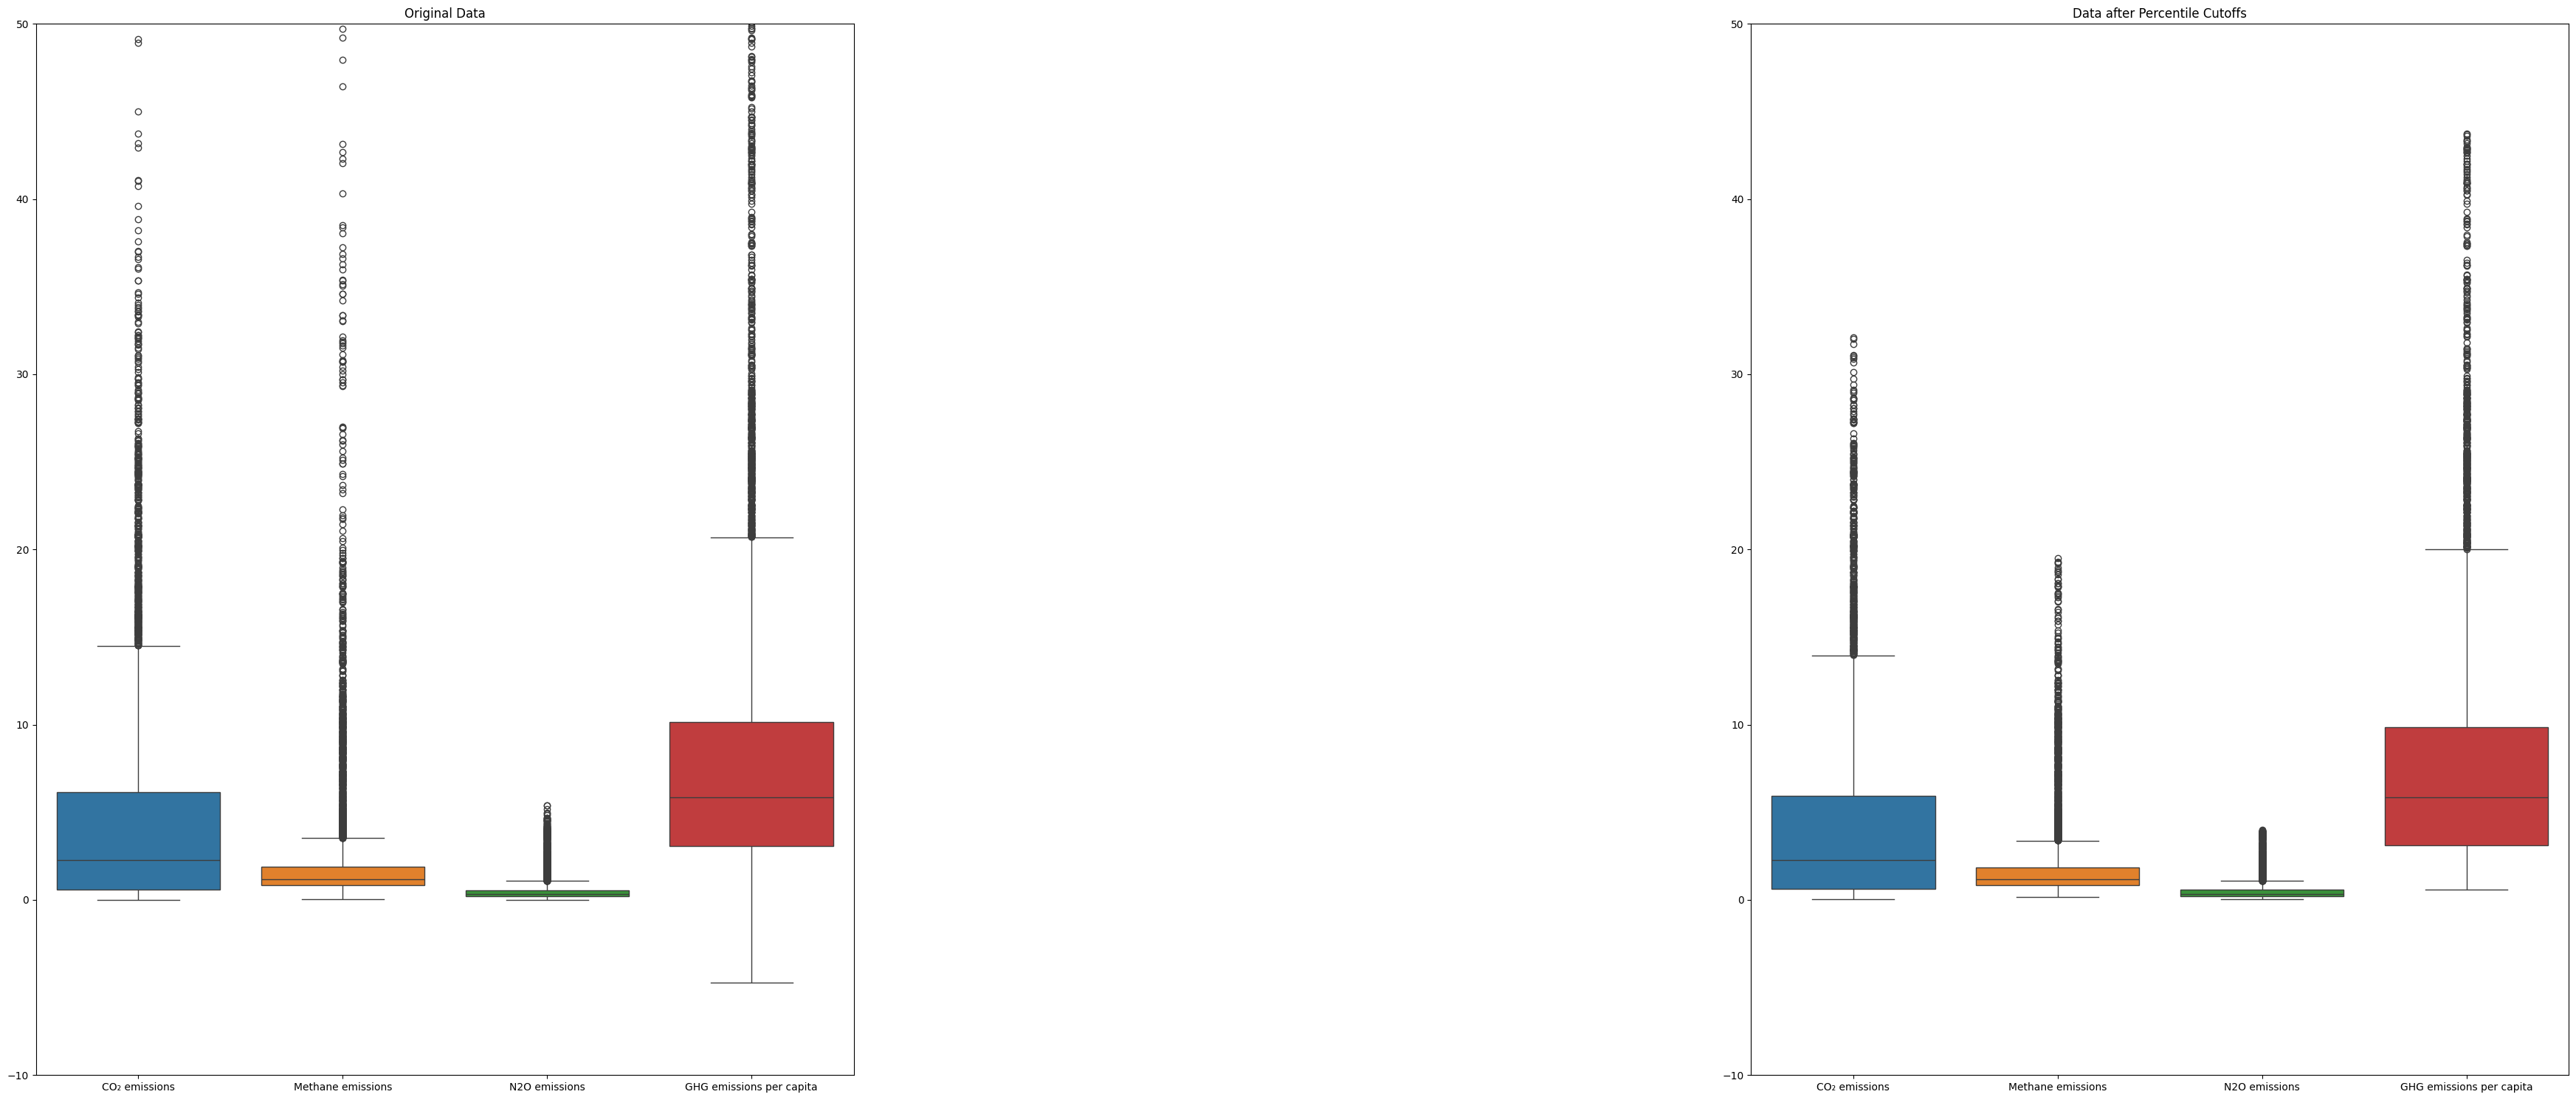

In [16]:
# Plotting data before and after outlier removal to compare
plt.figure(figsize=(35, 15))

# Original Data Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(data=df_combined[columns_to_check])
plt.title('Original Data')
#plt.xticks(rotation=45)
plt.ylim(-10, 50)

# Data after Percentile Cutoffs Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(data=preprocessed_data[columns_to_check])
plt.title('Data after Percentile Cutoffs')
#plt.xticks(rotation=45)
plt.ylim(-10, 50)

plt.tight_layout()
plt.show()

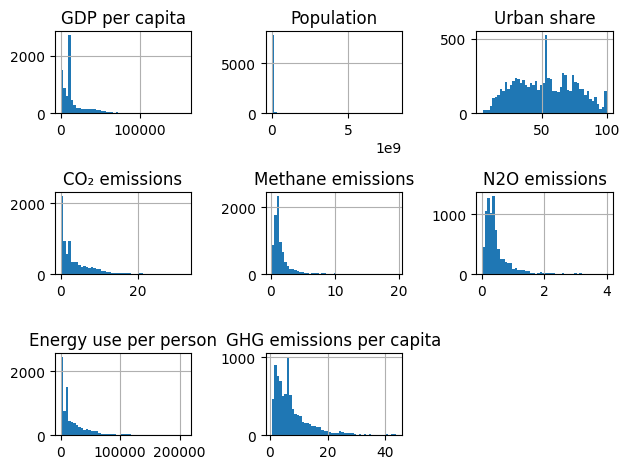

In [17]:
df=preprocessed_data

#histograms
df[numerical_columns].hist(bins=50)
plt.tight_layout()
plt.show()

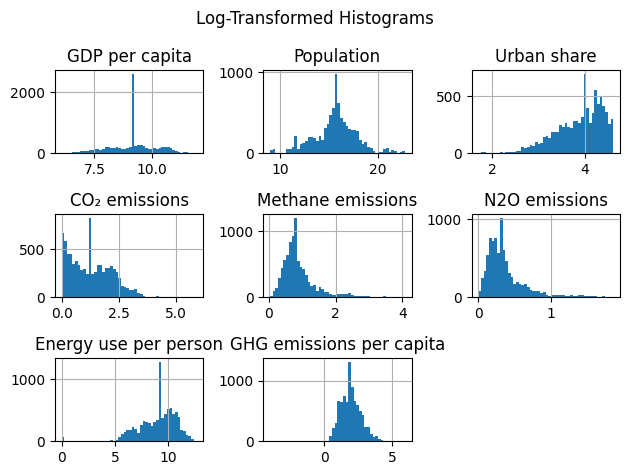

In [18]:
# Apply log transformation
df_log_transformed = df_combined[numerical_columns].apply(np.log1p)
df_log_transformed.hist(bins=50)
plt.suptitle('Log-Transformed Histograms')
plt.tight_layout()
plt.show()

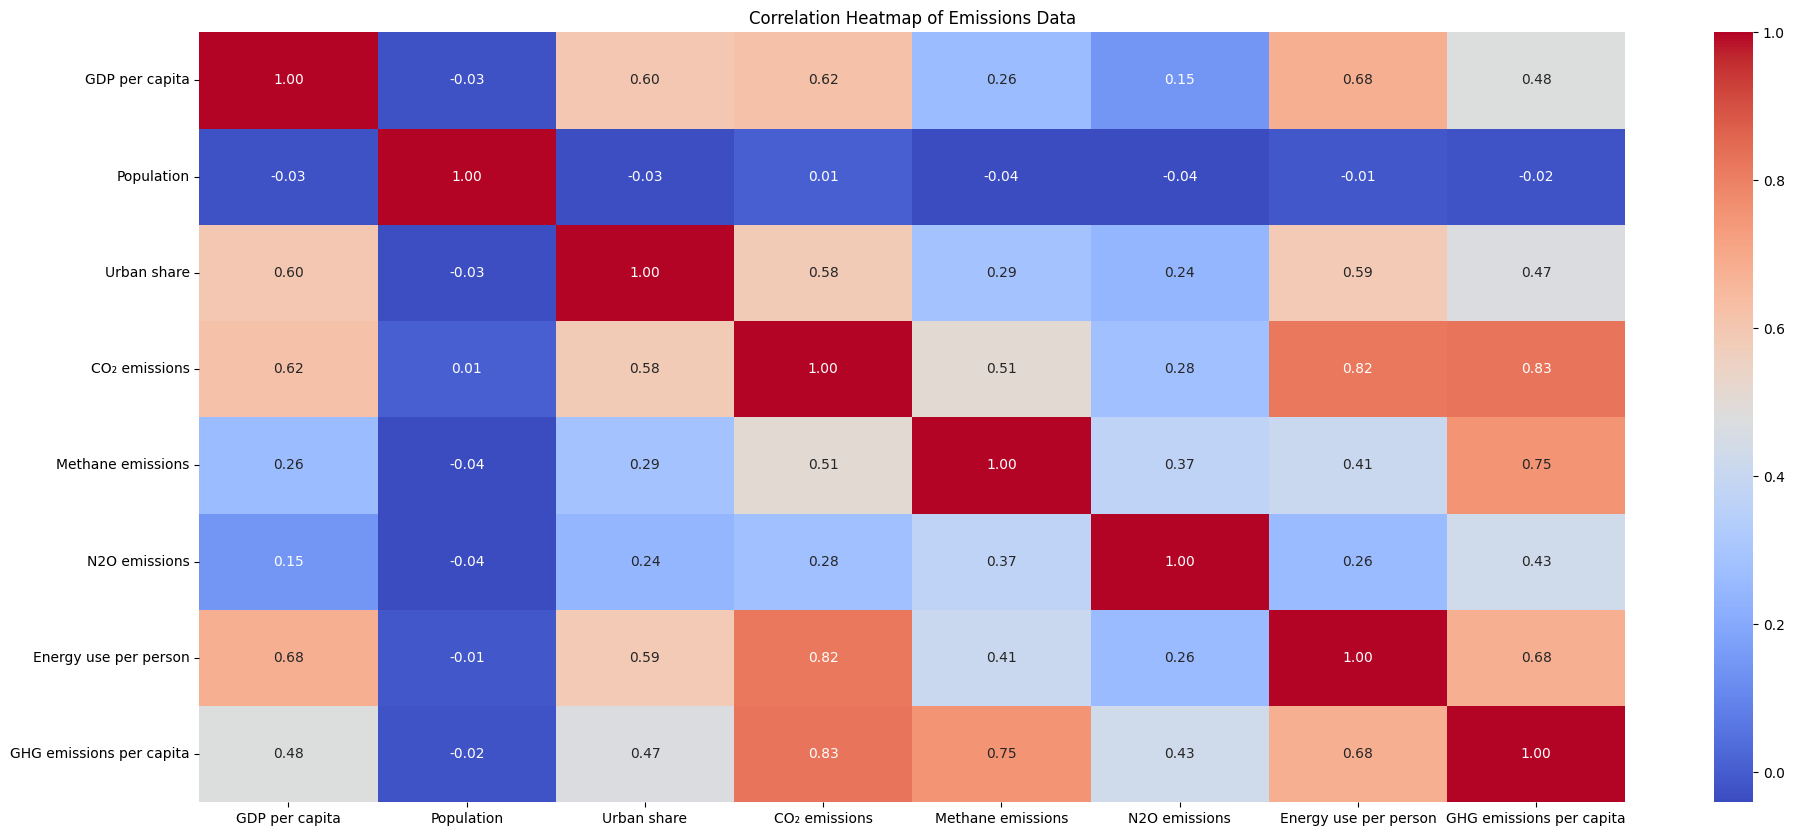

In [19]:
# Correlation heatmap
plt.figure(figsize=(23, 10))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Emissions Data")
plt.show()

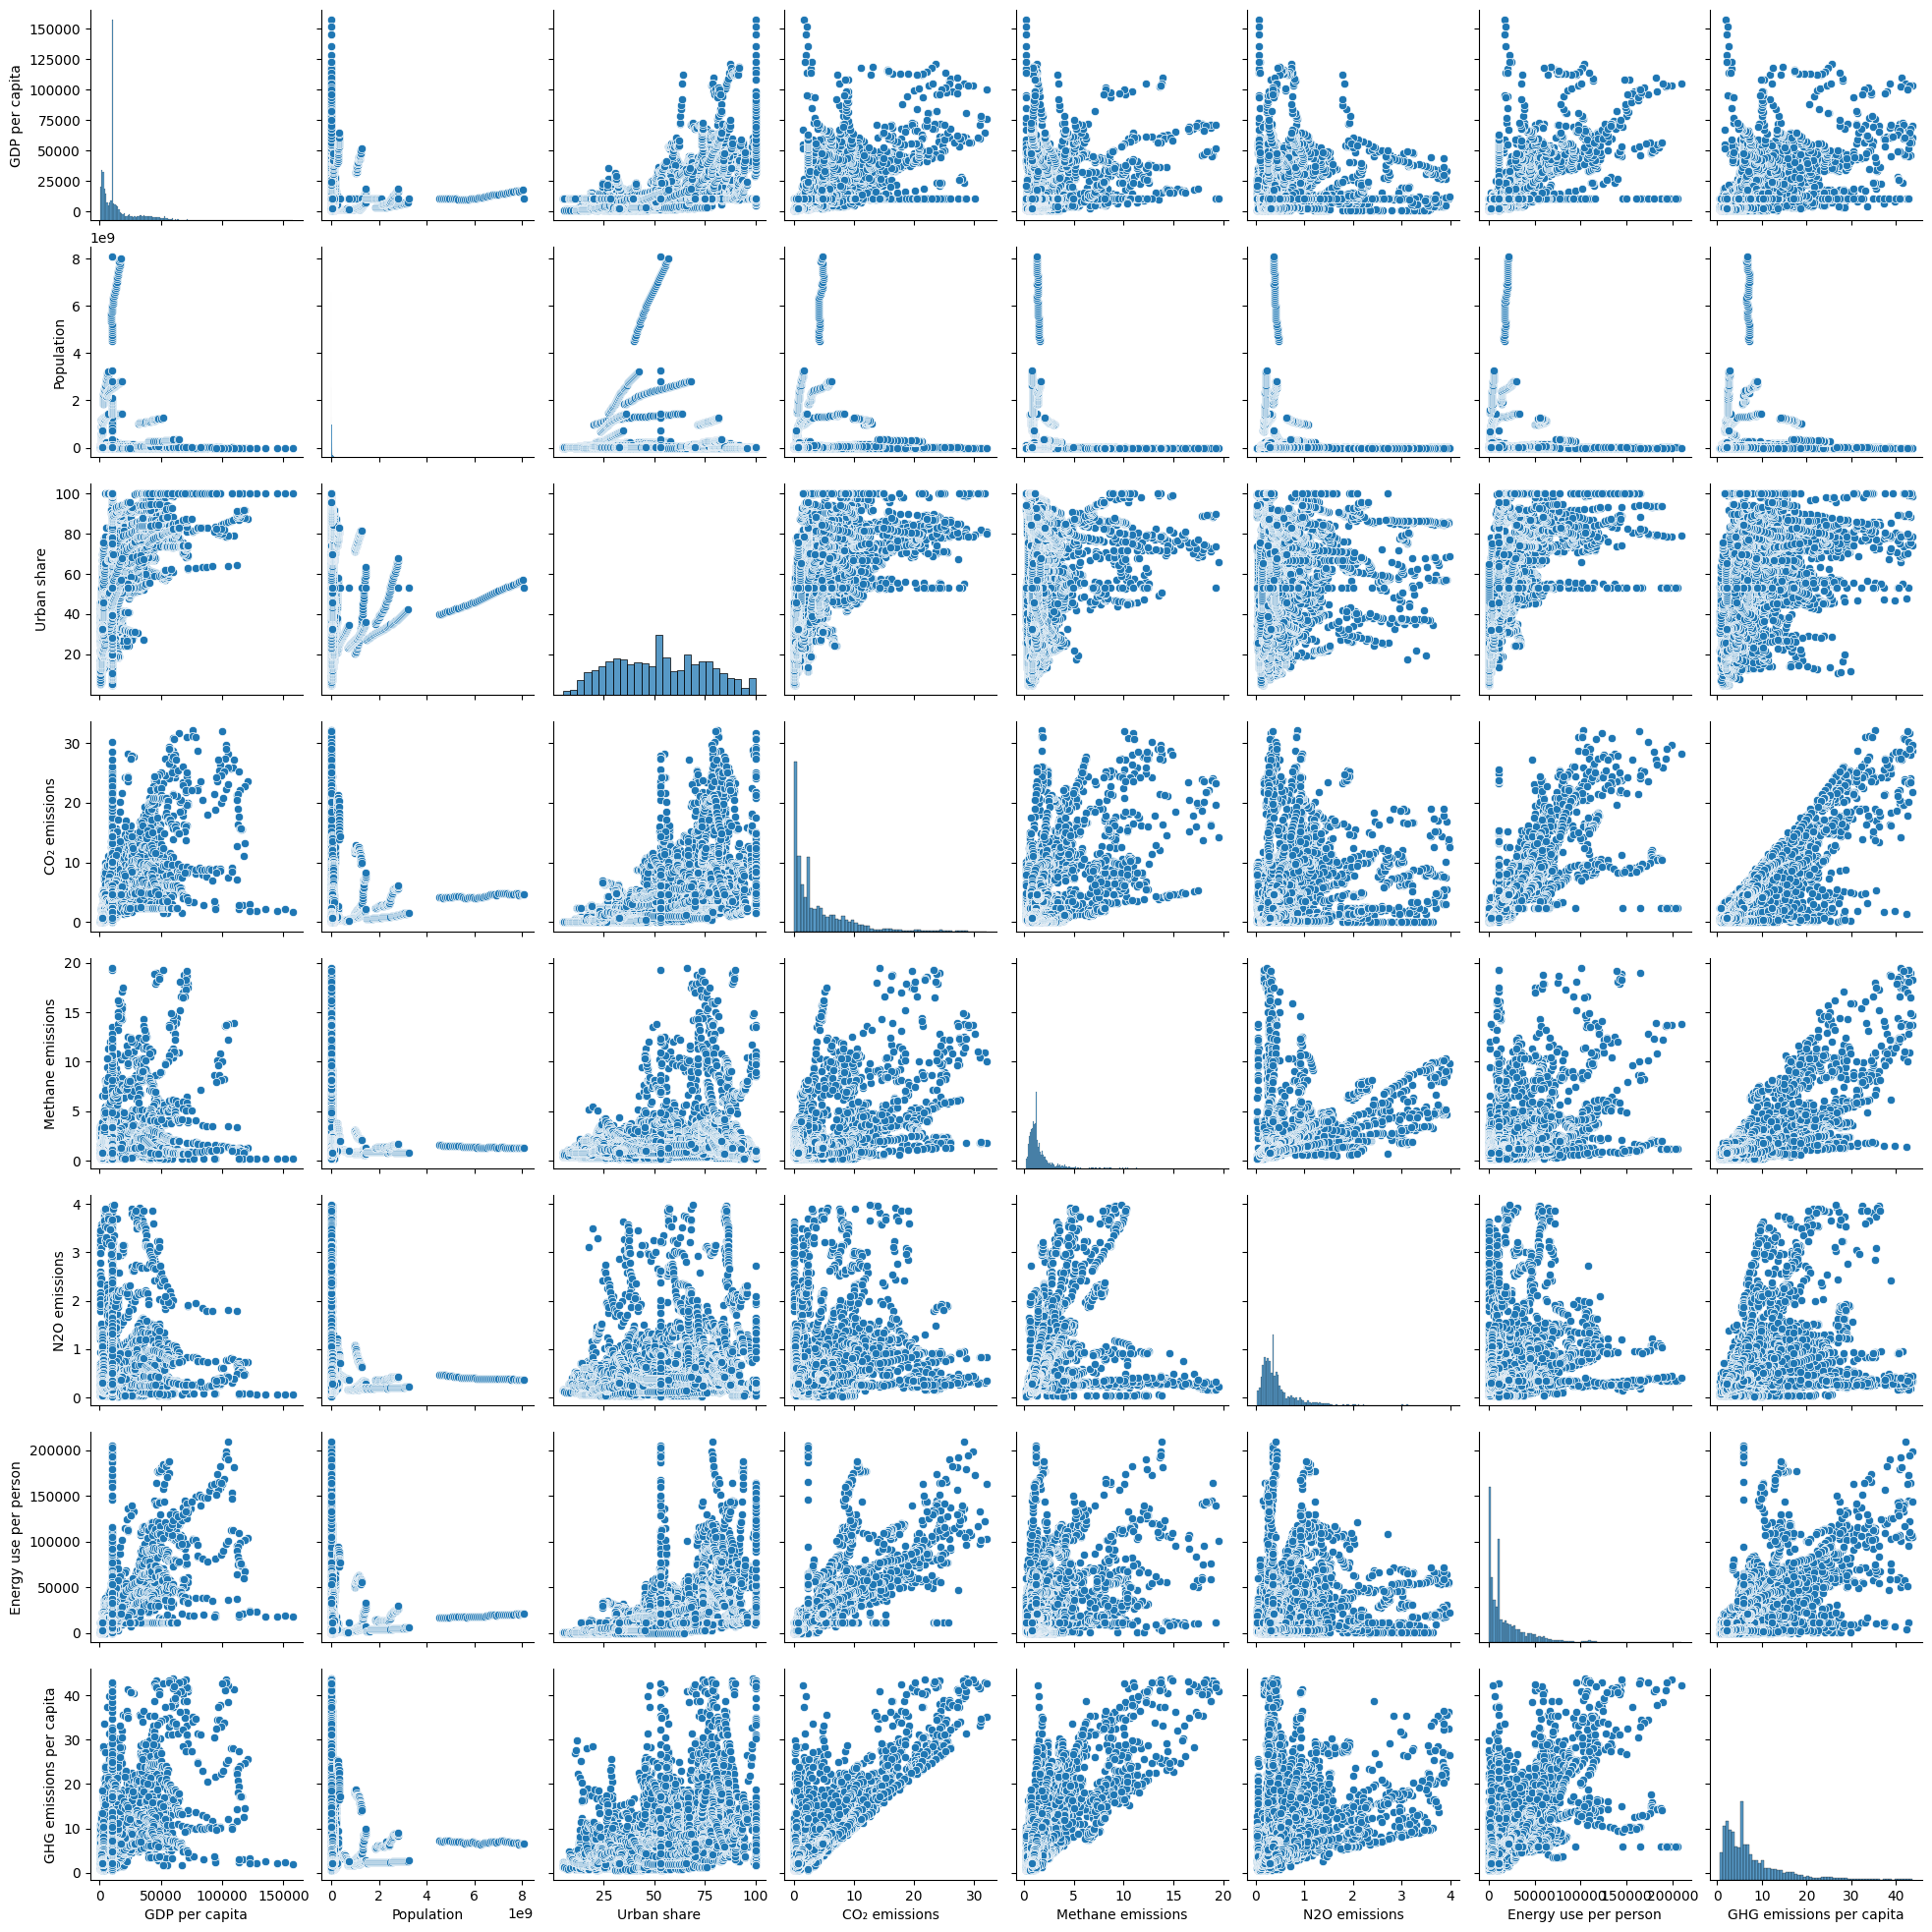

In [20]:
# Pairplot
pairplot=sns.pairplot(df[numerical_columns])
plt.xticks(rotation=45)
pairplot.savefig("pairplot_image.png", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# SavING the updated DataFrame back to a CSV file
cleaned_file_name = '/content/cleaned_ghg_emissions_dataset.csv'

#'df' is your cleaned DataFrame
df.to_csv(cleaned_file_name, index=False)

# Upload the cleaned data back to GCP bucket
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob('cleaned_ghg_emissions_dataset.csv')
blob.upload_from_filename(cleaned_file_name)

print("Cleaned dataset has been uploaded to the bucket.")


Cleaned dataset has been uploaded to the bucket.
